libraries

In [1]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import PolynomialFeatures

# Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.ensemble import VotingClassifier
from vecstack import stacking
from scipy.stats.mstats import gmean

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
from sklearn.externals import joblib
import pickle
from itertools import combinations
import gc
from tqdm import tqdm
import platform

# Keras
import tensorflow as tf
# Tensorflow warning off
if tf.__version__[0] < '2':
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    tf.logging.set_verbosity(tf.logging.ERROR)
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.constraints import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.preprocessing.image import *
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import *

from keras.models import Model, Sequential
from keras import Input
from keras import layers
from keras.optimizers import RMSprop
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


In [2]:
# 모형 학습 시 RMSE를 계산하는 함수
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 예측값을 저장할 폴더 생성
folder = 'Ensemble'
if not os.path.isdir(folder):
    os.mkdir(folder)

df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()

In [29]:
# ### Ensemble Models 
# 생성된 다수의 DNN 모형을 power mean하여 앙상블

# nf = 0
# for f in os.listdir(folder):
#     ext = os.path.splitext(f)[-1]
#     if ext == '.csv': 
#         s = pd.read_csv(folder+"/"+f)
#     else: 
#         continue
#     if len(s.columns) !=2:
#         continue
#     if nf == 0: 
#         slist = s
#     else: 
#         slist = pd.merge(slist, s, on="item_id")
#     nf += 1

# p = 4.5 # 이 값에 따라 성능이 달라짐 (p=1: 산술평균, p>1: 멱평균)    
# if nf >= 2:
#     pred = 0
#     for j in range(nf): pred = pred + slist.iloc[:,j+1]**p 
#     pred = pred / nf    
#     pred = pred**(1/p)

#     submission = pd.DataFrame({'item_id': slist.item_id, 'item_cnt_month': pred})
#     t = pd.Timestamp.now()
#     fname = f"p{p}mean_dnn_submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv"
#     submission.to_csv(fname, index=False)

1. 중분류 구매건수

In [2]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()


level = 'gds_grp_nm'

train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                            aggfunc=lambda x: len(x), fill_value=0).reset_index()


# 이상치(outlier)를 제거한다.
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다. -> 0.769
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

#from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
train_test.iloc[:, 1:] = mmscaler.fit_transform(train_test.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test.iloc[:,1:])
train_test = pd.concat([train_test.iloc[:,0], pd.DataFrame(pca)], axis=1)
display(train_test)

# 전처리 후 학습용과 제출용 데이터로 분리한다.
X_train = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
X_test = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)


seed = 2020
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

,cust_id,0,1,2,3,4,5,6,7,8,...,100,101,102,103,104,105,106,107,108,109
0,0,0.625380,0.034396,-0.672246,0.441779,0.159294,-0.598718,0.325886,-0.936302,0.305429,...,-0.143142,0.118564,-0.002334,0.089901,-0.111054,-0.021497,0.140365,0.117912,-0.126485,0.046712
1,1,-1.107635,-0.008147,-0.036582,-0.227227,-0.173067,0.257546,0.036107,-0.059078,-0.073846,...,0.030561,-0.018014,0.032755,0.015114,0.011464,-0.002095,-0.073120,-0.051948,0.005610,-0.007939
2,2,-1.099033,-0.109059,-0.020829,0.007957,-0.059710,0.090729,0.179059,-0.068382,0.062943,...,0.002262,0.035945,-0.017813,-0.008323,-0.036238,0.021623,0.038809,0.046284,0.007039,0.014445
3,3,0.265591,-0.619277,-0.279149,-0.187955,0.023135,-0.135279,-0.067050,0.675716,-0.159730,...,0.131376,0.064030,-0.118500,0.066814,-0.149491,-0.003301,0.486243,-0.482798,-0.028555,-0.156546
4,4,-1.141518,-0.191579,0.005533,-0.059629,0.026487,0.013643,-0.095080,0.043151,-0.057431,...,0.008822,0.004029,0.004533,-0.000862,-0.005974,-0.006765,0.007707,0.013415,-0.002152,0.008844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,-0.877498,0.236507,-0.127787,-0.066931,-0.135133,0.047662,0.136196,-0.051518,-0.006189,...,0.100014,-0.477439,-0.028659,0.204758,-0.015639,0.083038,0.010453,-0.005576,-0.006840,0.081172
5978,5978,-1.162111,-0.159106,0.019576,0.078777,0.026611,-0.007421,-0.020261,0.025530,-0.021468,...,0.005455,0.005500,0.013200,0.006884,0.011396,0.006313,-0.050464,-0.032066,-0.036101,-0.007855
5979,5979,0.199450,1.781264,-0.540263,0.071173,0.331206,1.250888,0.351207,-0.141133,-0.117322,...,0.100453,0.028486,-0.128008,0.088439,-0.112445,-0.079405,0.109667,0.038992,-0.088774,0.054421
5980,5980,-0.635700,-0.227858,-0.237216,0.009492,-0.166560,-0.074526,0.129139,-0.274902,-0.380003,...,-0.285796,0.651523,0.113559,-0.241631,0.065565,0.000818,-0.040256,-0.085648,-0.044685,-0.053650


In [27]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
    
    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)
    
    # Make submissions
    submission = pd.DataFrame({
        "item_id": IDtest, 
        "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

 20%|████████████████▊                                                                   | 1/5 [00:03<00:12,  3.00s/it]

0.7463076869613567 SEED: 1782


 40%|█████████████████████████████████▌                                                  | 2/5 [00:06<00:09,  3.19s/it]

0.7486012649430082 SEED: 9197


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:09<00:06,  3.10s/it]

0.7524716777870448 SEED: 1374


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:12<00:03,  3.15s/it]

0.7474284125660273 SEED: 9647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.24s/it]

0.7472546566583265 SEED: 8924


2. 대분류 구매건수

In [30]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()


level = 'gds_grp_mclas_nm'

train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                            aggfunc=lambda x: len(x), fill_value=0).reset_index()


# 이상치(outlier)를 제거한다.
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다. -> 0.769
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

#from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
train_test.iloc[:, 1:] = mmscaler.fit_transform(train_test.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test.iloc[:,1:])
train_test = pd.concat([train_test.iloc[:,0], pd.DataFrame(pca)], axis=1)
display(train_test)

# 전처리 후 학습용과 제출용 데이터로 분리한다.
X_train = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
X_test = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)


seed = 2020
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

,cust_id,0,1,2,3,4,5,6,7,8,...,25,26,27,28,29,30,31,32,33,34
0,0,0.808812,0.047621,-0.382530,0.136842,0.068270,-1.067826,0.097073,0.064659,0.123847,...,0.278258,-0.198159,-0.226099,-0.038080,0.324296,-0.434571,-0.308631,-0.016363,0.194200,-0.018975
1,1,-0.942326,0.181016,0.039485,0.224548,0.165447,0.185474,0.260437,0.067577,-0.233817,...,-0.035076,-0.147834,0.062239,0.060819,-0.054463,-0.387346,0.112056,-0.059185,0.006323,-0.030976
2,2,-0.939487,0.072728,-0.171136,0.257513,-0.163384,-0.015842,-0.109646,0.098185,-0.189282,...,0.057341,0.047966,-0.038936,-0.112071,-0.006490,0.062245,-0.004990,0.035366,0.044459,0.039179
3,3,0.176414,-0.540114,-0.095850,0.039596,0.054163,0.377580,0.169790,-0.019942,0.183439,...,0.156863,-0.014416,-0.061704,0.120444,-0.374014,0.177117,-0.243579,0.075744,-0.142311,-0.229687
4,4,-1.006475,-0.015659,0.083409,-0.036429,0.082568,-0.020770,0.012661,-0.029358,0.030033,...,0.008659,0.040425,-0.007492,0.042274,0.049531,-0.034650,-0.017044,-0.018064,0.021210,-0.000362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,-0.527805,0.460797,-0.064967,-0.029257,0.232430,-0.141500,0.104384,0.065651,-0.706434,...,-0.477599,0.215720,0.023805,0.367133,0.026163,0.424302,-0.089105,-0.048746,0.062714,-0.055811
5978,5978,-1.038196,0.022598,0.023371,-0.003908,0.008111,0.030509,-0.068062,-0.030968,0.011029,...,0.106910,0.017061,0.158339,-0.014808,-0.045128,0.014905,-0.012643,-0.058065,0.033216,-0.046763
5979,5979,0.672151,1.288926,0.047105,0.442555,-0.225962,0.620944,-0.542938,-0.306575,-0.724191,...,-0.267473,0.172990,0.246498,-0.123809,-0.203993,-0.005225,-0.029028,0.124641,0.155520,0.100988
5980,5980,-0.561052,-0.015907,0.100263,0.082922,-0.023670,0.353346,0.424770,-0.039177,0.215357,...,0.149904,-0.020741,-0.158265,0.161862,-0.201403,-0.103223,-0.567873,-0.410687,-0.080075,0.002968


In [31]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
    
    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)
    
    # Make submissions
    submission = pd.DataFrame({
        "item_id": IDtest, 
        "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

 20%|████████████████▊                                                                   | 1/5 [00:03<00:14,  3.65s/it]

0.7616112385321101 SEED: 9057


 40%|█████████████████████████████████▌                                                  | 2/5 [00:07<00:11,  3.79s/it]

0.7567113219349457 SEED: 8840


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:11<00:07,  3.68s/it]

0.7600995621351126 SEED: 2103


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:14<00:03,  3.63s/it]

0.7553734014456491 SEED: 3043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.57s/it]

0.7567981998887963 SEED: 5221


3. 중분류 구매여부

In [32]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()


level = 'gds_grp_nm'

train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                           aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0).reset_index()


# 이상치(outlier)를 제거한다.
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다. -> 0.769
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

#from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
train_test.iloc[:, 1:] = mmscaler.fit_transform(train_test.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test.iloc[:,1:])
train_test = pd.concat([train_test.iloc[:,0], pd.DataFrame(pca)], axis=1)
display(train_test)

# 전처리 후 학습용과 제출용 데이터로 분리한다.
X_train = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
X_test = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)


i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

,cust_id,0,1,2,3,4,5,6,7,8,...,101,102,103,104,105,106,107,108,109,110
0,0,1.031835,0.212301,-0.922307,-0.869803,-0.305008,0.092058,0.831769,-0.575745,-0.703853,...,0.102421,-0.318619,-0.375416,-0.050509,0.185363,-0.019726,-0.122237,-0.086713,-0.053711,-0.077012
1,1,-1.545397,-0.120407,0.028675,0.202452,0.264835,0.240070,0.129344,0.058812,0.209729,...,0.028266,0.074902,0.029886,0.116798,-0.031030,-0.049614,0.024517,0.003476,0.001157,0.006372
2,2,-1.415123,-0.065534,0.005330,-0.016653,0.142608,0.400511,-0.053878,-0.125965,-0.270389,...,0.018800,0.036842,-0.011082,-0.020539,-0.010853,-0.012236,-0.003550,-0.000766,0.007166,0.015099
3,3,0.865498,-1.222110,-0.553205,0.022980,0.309707,-0.115284,-0.423851,0.164560,0.401825,...,0.122099,0.050478,0.119724,-0.141897,-0.014390,0.095265,-0.023132,0.142257,0.325156,0.171970
4,4,-1.341069,-0.078229,-0.045112,0.219325,-0.030194,-0.500378,0.017921,0.145940,-0.016312,...,0.012135,0.031032,-0.017324,-0.006011,0.007325,-0.018732,0.004144,-0.010431,-0.004584,-0.006360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,-1.161452,0.308622,-0.139144,-0.117040,0.072620,0.152300,-0.058142,-0.208458,-0.120671,...,0.004387,-0.135064,0.031170,-0.002395,-0.009385,0.033274,0.079296,0.230744,-0.209229,-0.247969
5978,5978,-1.547982,-0.166368,0.062790,-0.058637,-0.039730,0.145217,0.182716,0.213168,0.241474,...,-0.017176,-0.011808,-0.000613,-0.003491,-0.025970,-0.001241,0.008654,-0.008849,-0.015761,-0.011166
5979,5979,0.204833,1.663809,-0.728419,0.605944,0.811258,1.091609,-0.392112,1.131950,-0.592724,...,-0.523407,0.207549,-0.355611,-0.084467,0.018351,0.011924,0.144681,0.012927,0.108045,-0.044070
5980,5980,-0.925491,-0.298534,-0.188338,-0.024190,0.231828,0.287504,0.755301,-0.127350,0.329944,...,-0.028420,-0.098941,-0.130566,0.075247,-0.050180,0.088172,-0.168739,-0.393781,0.228118,0.392946


In [33]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
    
    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)
    
    # Make submissions
    submission = pd.DataFrame({
        "item_id": IDtest, 
        "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

 20%|████████████████▊                                                                   | 1/5 [00:04<00:17,  4.49s/it]

0.7412557339449541 SEED: 9057


 40%|█████████████████████████████████▌                                                  | 2/5 [00:08<00:13,  4.44s/it]

0.7484448846260774 SEED: 8840


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:12<00:08,  4.25s/it]

0.7494830761745899 SEED: 2103


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:17<00:04,  4.35s/it]

0.7459297678621073 SEED: 3043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.15s/it]

0.7396267723102585 SEED: 5221


4. 대분류 구매여부

In [34]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()


level = 'gds_grp_mclas_nm'

train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                           aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0).reset_index()


# 이상치(outlier)를 제거한다.
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다. -> 0.769
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

#from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
train_test.iloc[:, 1:] = mmscaler.fit_transform(train_test.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test.iloc[:,1:])
train_test = pd.concat([train_test.iloc[:,0], pd.DataFrame(pca)], axis=1)
display(train_test)

# 전처리 후 학습용과 제출용 데이터로 분리한다.
X_train = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
X_test = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)


i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

,cust_id,0,1,2,3,4,5,6,7,8,...,26,27,28,29,30,31,32,33,34,35
0,0,1.436058,-0.040728,-0.376852,0.244498,-0.337669,0.594535,1.160821,-0.507886,-0.026341,...,0.371315,-0.820841,0.280656,0.359050,-0.052447,0.167750,-0.028469,0.045124,0.103598,0.014635
1,1,-1.495079,0.426246,0.603980,0.267780,0.167863,-0.341812,0.074077,0.082130,-0.268278,...,-0.027723,-0.408299,-0.796369,-0.191770,0.136208,0.175161,-0.027328,0.023678,0.019509,-0.013586
2,2,-1.486196,0.137751,0.094870,0.455594,0.025952,0.268160,0.156926,-0.156983,-0.082030,...,0.102234,0.202870,0.137714,0.092741,-0.046748,-0.249884,0.133006,0.062282,-0.045456,-0.040493
3,3,0.826307,-0.968225,0.253546,0.553680,-0.338130,-0.531447,-0.663852,0.274229,0.311605,...,-0.615561,0.226854,0.448593,0.001418,-0.397996,-0.505601,-0.206288,-0.023323,-0.058132,-0.078507
4,4,-1.388948,0.099101,0.054519,-0.485316,-0.493745,0.040495,0.094735,-0.274916,-0.333733,...,0.094130,0.096581,-0.122793,0.078391,-0.059339,-0.210875,0.119112,0.095087,-0.033616,0.010124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,-0.758481,0.812565,-0.108292,0.172876,0.196507,-0.143411,0.183231,0.159825,-0.234539,...,-0.780837,-0.074323,-0.534725,-0.266745,-0.442471,-0.236793,-0.081901,0.159949,-0.030645,0.010190
5978,5978,-1.564872,0.227113,0.097719,0.005096,-0.014250,0.254983,-0.491875,-0.342264,0.369359,...,-0.097276,-0.100308,0.012817,0.030391,0.023927,0.100438,-0.032773,-0.034280,-0.015645,0.006128
5979,5979,1.010739,1.482501,1.119399,0.718032,-0.021002,0.340607,-0.337983,0.478843,0.405145,...,0.111127,0.135636,-0.055767,-0.729023,-0.262131,0.856770,0.272822,0.424178,-0.637153,-0.439690
5980,5980,-0.907570,0.014547,0.360717,0.103525,0.415867,-0.849732,0.382268,-0.345673,0.521682,...,-0.653179,0.014776,0.284553,-0.030792,-0.207601,-0.053542,-0.043660,-0.118073,-0.046550,-0.100628


In [35]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
    
    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)
    
    # Make submissions
    submission = pd.DataFrame({
        "item_id": IDtest, 
        "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

 20%|████████████████▊                                                                   | 1/5 [00:04<00:18,  4.52s/it]

0.7575974770642201 SEED: 9057


 40%|█████████████████████████████████▌                                                  | 2/5 [00:08<00:12,  4.29s/it]

0.7543048026132889 SEED: 8840


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:12<00:08,  4.33s/it]

0.7567808242980261 SEED: 2103


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:17<00:04,  4.60s/it]

0.7553299624687241 SEED: 3043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.35s/it]

0.7562421809841533 SEED: 5221


5. 중분류 & 대분류 구매건수

In [42]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()


level = 'gds_grp_nm'

train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                            aggfunc=lambda x: len(x), fill_value=0).reset_index()


# 이상치(outlier)를 제거한다.
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다. -> 0.769
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

#from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
train_test.iloc[:, 1:] = mmscaler.fit_transform(train_test.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test.iloc[:,1:])
train_test = pd.concat([train_test.iloc[:,0], pd.DataFrame(pca)], axis=1)
display(train_test)

# 전처리 후 학습용과 제출용 데이터로 분리한다.
X_train_nm = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
X_test_nm = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)



df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()


level = 'gds_grp_mclas_nm'

train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                            aggfunc=lambda x: len(x), fill_value=0).reset_index()


# 이상치(outlier)를 제거한다.
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다. -> 0.769
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

#from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
train_test.iloc[:, 1:] = mmscaler.fit_transform(train_test.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test.iloc[:,1:])
train_test = pd.concat([train_test.iloc[:,0], pd.DataFrame(pca)], axis=1)
display(train_test)

# 전처리 후 학습용과 제출용 데이터로 분리한다.
X_train_mclas = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
X_test_mclas = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)

### 중분류 구매건수 nm과 대분류 구매건수 mclas를 합친다

X_train = pd.concat([X_train_nm, X_train_mclas], axis=1)
X_test = pd.concat([X_test_nm, X_test_mclas], axis=1)


i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

,cust_id,0,1,2,3,4,5,6,7,8,...,100,101,102,103,104,105,106,107,108,109
0,0,0.625380,0.034396,-0.672246,0.441779,0.159294,-0.598718,0.325886,-0.936302,0.305429,...,-0.143142,0.118564,-0.002334,0.089901,-0.111054,-0.021497,0.140365,0.117912,-0.126485,0.046712
1,1,-1.107635,-0.008147,-0.036582,-0.227227,-0.173067,0.257546,0.036107,-0.059078,-0.073846,...,0.030561,-0.018014,0.032755,0.015114,0.011464,-0.002095,-0.073120,-0.051948,0.005610,-0.007939
2,2,-1.099033,-0.109059,-0.020829,0.007957,-0.059710,0.090729,0.179059,-0.068382,0.062943,...,0.002262,0.035945,-0.017813,-0.008323,-0.036238,0.021623,0.038809,0.046284,0.007039,0.014445
3,3,0.265591,-0.619277,-0.279149,-0.187955,0.023135,-0.135279,-0.067050,0.675716,-0.159730,...,0.131376,0.064030,-0.118500,0.066814,-0.149491,-0.003301,0.486243,-0.482798,-0.028555,-0.156546
4,4,-1.141518,-0.191579,0.005533,-0.059629,0.026487,0.013643,-0.095080,0.043151,-0.057431,...,0.008822,0.004029,0.004533,-0.000862,-0.005974,-0.006765,0.007707,0.013415,-0.002152,0.008844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,-0.877498,0.236507,-0.127787,-0.066931,-0.135133,0.047662,0.136196,-0.051518,-0.006189,...,0.100014,-0.477439,-0.028659,0.204758,-0.015639,0.083038,0.010453,-0.005576,-0.006840,0.081172
5978,5978,-1.162111,-0.159106,0.019576,0.078777,0.026611,-0.007421,-0.020261,0.025530,-0.021468,...,0.005455,0.005500,0.013200,0.006884,0.011396,0.006313,-0.050464,-0.032066,-0.036101,-0.007855
5979,5979,0.199450,1.781264,-0.540263,0.071173,0.331206,1.250888,0.351207,-0.141133,-0.117322,...,0.100453,0.028486,-0.128008,0.088439,-0.112445,-0.079405,0.109667,0.038992,-0.088774,0.054421
5980,5980,-0.635700,-0.227858,-0.237216,0.009492,-0.166560,-0.074526,0.129139,-0.274902,-0.380003,...,-0.285796,0.651523,0.113559,-0.241631,0.065565,0.000818,-0.040256,-0.085648,-0.044685,-0.053650


,cust_id,0,1,2,3,4,5,6,7,8,...,25,26,27,28,29,30,31,32,33,34
0,0,0.808812,0.047621,-0.382530,0.136842,0.068270,-1.067826,0.097073,0.064659,0.123847,...,0.278258,-0.198159,-0.226099,-0.038080,0.324296,-0.434571,-0.308631,-0.016363,0.194200,-0.018975
1,1,-0.942326,0.181016,0.039485,0.224548,0.165447,0.185474,0.260437,0.067577,-0.233817,...,-0.035076,-0.147834,0.062239,0.060819,-0.054463,-0.387346,0.112056,-0.059185,0.006323,-0.030976
2,2,-0.939487,0.072728,-0.171136,0.257513,-0.163384,-0.015842,-0.109646,0.098185,-0.189282,...,0.057341,0.047966,-0.038936,-0.112071,-0.006490,0.062245,-0.004990,0.035366,0.044459,0.039179
3,3,0.176414,-0.540114,-0.095850,0.039596,0.054163,0.377580,0.169790,-0.019942,0.183439,...,0.156863,-0.014416,-0.061704,0.120444,-0.374014,0.177117,-0.243579,0.075744,-0.142311,-0.229687
4,4,-1.006475,-0.015659,0.083409,-0.036429,0.082568,-0.020770,0.012661,-0.029358,0.030033,...,0.008659,0.040425,-0.007492,0.042274,0.049531,-0.034650,-0.017044,-0.018064,0.021210,-0.000362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,-0.527805,0.460797,-0.064967,-0.029257,0.232430,-0.141500,0.104384,0.065651,-0.706434,...,-0.477599,0.215720,0.023805,0.367133,0.026163,0.424302,-0.089105,-0.048746,0.062714,-0.055811
5978,5978,-1.038196,0.022598,0.023371,-0.003908,0.008111,0.030509,-0.068062,-0.030968,0.011029,...,0.106910,0.017061,0.158339,-0.014808,-0.045128,0.014905,-0.012643,-0.058065,0.033216,-0.046763
5979,5979,0.672151,1.288926,0.047105,0.442555,-0.225962,0.620944,-0.542938,-0.306575,-0.724191,...,-0.267473,0.172990,0.246498,-0.123809,-0.203993,-0.005225,-0.029028,0.124641,0.155520,0.100988
5980,5980,-0.561052,-0.015907,0.100263,0.082922,-0.023670,0.353346,0.424770,-0.039177,0.215357,...,0.149904,-0.020741,-0.158265,0.161862,-0.201403,-0.103223,-0.567873,-0.410687,-0.080075,0.002968


In [44]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
    
    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)
    
    # Make submissions
    submission = pd.DataFrame({
        "item_id": IDtest, 
        "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

 20%|████████████████▊                                                                   | 1/5 [00:05<00:22,  5.58s/it]

0.7549954823463997 SEED: 1030


 40%|█████████████████████████████████▌                                                  | 2/5 [00:09<00:15,  5.20s/it]

0.7503388240200168 SEED: 5345


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:14<00:10,  5.12s/it]

0.7455952877397832 SEED: 6625


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:19<00:04,  4.87s/it]

0.7541614539894357 SEED: 2816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.75s/it]

0.751207603558521 SEED: 7695


6. 중분류 & 대분류 구매여부

In [45]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()


level = 'gds_grp_nm'

train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                           aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0).reset_index()


# 이상치(outlier)를 제거한다.
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다. -> 0.769
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

#from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
train_test.iloc[:, 1:] = mmscaler.fit_transform(train_test.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test.iloc[:,1:])
train_test = pd.concat([train_test.iloc[:,0], pd.DataFrame(pca)], axis=1)
display(train_test)

# 전처리 후 학습용과 제출용 데이터로 분리한다.
X_train_nm = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
X_test_nm = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)



df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()


level = 'gds_grp_mclas_nm'

train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                           aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0).reset_index()


# 이상치(outlier)를 제거한다.
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다. -> 0.769
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

#from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
train_test.iloc[:, 1:] = mmscaler.fit_transform(train_test.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test.iloc[:,1:])
train_test = pd.concat([train_test.iloc[:,0], pd.DataFrame(pca)], axis=1)
display(train_test)

# 전처리 후 학습용과 제출용 데이터로 분리한다.
X_train_mclas = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
X_test_mclas = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)

### 중분류 구매건수 nm과 대분류 구매건수 mclas를 합친다

X_train = pd.concat([X_train_nm, X_train_mclas], axis=1)
X_test = pd.concat([X_test_nm, X_test_mclas], axis=1)


i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

,cust_id,0,1,2,3,4,5,6,7,8,...,101,102,103,104,105,106,107,108,109,110
0,0,1.031835,0.212301,-0.922307,-0.869803,-0.305008,0.092058,0.831769,-0.575745,-0.703853,...,0.102421,-0.318619,-0.375416,-0.050509,0.185363,-0.019726,-0.122237,-0.086713,-0.053711,-0.077012
1,1,-1.545397,-0.120407,0.028675,0.202452,0.264835,0.240070,0.129344,0.058812,0.209729,...,0.028266,0.074902,0.029886,0.116798,-0.031030,-0.049614,0.024517,0.003476,0.001157,0.006372
2,2,-1.415123,-0.065534,0.005330,-0.016653,0.142608,0.400511,-0.053878,-0.125965,-0.270389,...,0.018800,0.036842,-0.011082,-0.020539,-0.010853,-0.012236,-0.003550,-0.000766,0.007166,0.015099
3,3,0.865498,-1.222110,-0.553205,0.022980,0.309707,-0.115284,-0.423851,0.164560,0.401825,...,0.122099,0.050478,0.119724,-0.141897,-0.014390,0.095265,-0.023132,0.142257,0.325156,0.171970
4,4,-1.341069,-0.078229,-0.045112,0.219325,-0.030194,-0.500378,0.017921,0.145940,-0.016312,...,0.012135,0.031032,-0.017324,-0.006011,0.007325,-0.018732,0.004144,-0.010431,-0.004584,-0.006360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,-1.161452,0.308622,-0.139144,-0.117040,0.072620,0.152300,-0.058142,-0.208458,-0.120671,...,0.004387,-0.135064,0.031170,-0.002395,-0.009385,0.033274,0.079296,0.230744,-0.209229,-0.247969
5978,5978,-1.547982,-0.166368,0.062790,-0.058637,-0.039730,0.145217,0.182716,0.213168,0.241474,...,-0.017176,-0.011808,-0.000613,-0.003491,-0.025970,-0.001241,0.008654,-0.008849,-0.015761,-0.011166
5979,5979,0.204833,1.663809,-0.728419,0.605944,0.811258,1.091609,-0.392112,1.131950,-0.592724,...,-0.523407,0.207549,-0.355611,-0.084467,0.018351,0.011924,0.144681,0.012927,0.108045,-0.044070
5980,5980,-0.925491,-0.298534,-0.188338,-0.024190,0.231828,0.287504,0.755301,-0.127350,0.329944,...,-0.028420,-0.098941,-0.130566,0.075247,-0.050180,0.088172,-0.168739,-0.393781,0.228118,0.392946


,cust_id,0,1,2,3,4,5,6,7,8,...,26,27,28,29,30,31,32,33,34,35
0,0,1.436058,-0.040728,-0.376852,0.244498,-0.337669,0.594535,1.160821,-0.507886,-0.026341,...,0.371315,-0.820841,0.280656,0.359050,-0.052447,0.167750,-0.028469,0.045124,0.103598,0.014635
1,1,-1.495079,0.426246,0.603980,0.267780,0.167863,-0.341812,0.074077,0.082130,-0.268278,...,-0.027723,-0.408299,-0.796369,-0.191770,0.136208,0.175161,-0.027328,0.023678,0.019509,-0.013586
2,2,-1.486196,0.137751,0.094870,0.455594,0.025952,0.268160,0.156926,-0.156983,-0.082030,...,0.102234,0.202870,0.137714,0.092741,-0.046748,-0.249884,0.133006,0.062282,-0.045456,-0.040493
3,3,0.826307,-0.968225,0.253546,0.553680,-0.338130,-0.531447,-0.663852,0.274229,0.311605,...,-0.615561,0.226854,0.448593,0.001418,-0.397996,-0.505601,-0.206288,-0.023323,-0.058132,-0.078507
4,4,-1.388948,0.099101,0.054519,-0.485316,-0.493745,0.040495,0.094735,-0.274916,-0.333733,...,0.094130,0.096581,-0.122793,0.078391,-0.059339,-0.210875,0.119112,0.095087,-0.033616,0.010124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,-0.758481,0.812565,-0.108292,0.172876,0.196507,-0.143411,0.183231,0.159825,-0.234539,...,-0.780837,-0.074323,-0.534725,-0.266745,-0.442471,-0.236793,-0.081901,0.159949,-0.030645,0.010190
5978,5978,-1.564872,0.227113,0.097719,0.005096,-0.014250,0.254983,-0.491875,-0.342264,0.369359,...,-0.097276,-0.100308,0.012817,0.030391,0.023927,0.100438,-0.032773,-0.034280,-0.015645,0.006128
5979,5979,1.010739,1.482501,1.119399,0.718032,-0.021002,0.340607,-0.337983,0.478843,0.405145,...,0.111127,0.135636,-0.055767,-0.729023,-0.262131,0.856770,0.272822,0.424178,-0.637153,-0.439690
5980,5980,-0.907570,0.014547,0.360717,0.103525,0.415867,-0.849732,0.382268,-0.345673,0.521682,...,-0.653179,0.014776,0.284553,-0.030792,-0.207601,-0.053542,-0.043660,-0.118073,-0.046550,-0.100628


In [46]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
    
    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)
    
    # Make submissions
    submission = pd.DataFrame({
        "item_id": IDtest, 
        "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

 20%|████████████████▊                                                                   | 1/5 [00:04<00:18,  4.70s/it]

0.7460166458159577 SEED: 3405


 40%|█████████████████████████████████▌                                                  | 2/5 [00:09<00:14,  4.71s/it]

0.7483971017514596 SEED: 9450


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:13<00:09,  4.65s/it]

0.744726508201279 SEED: 1922


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:19<00:04,  4.98s/it]

0.7509295941061996 SEED: 3863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.77s/it]

0.7482798165137614 SEED: 533


7. 중분류 구매건수 & 대분류 구매여부

In [47]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()


level = 'gds_grp_nm'

train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                            aggfunc=lambda x: len(x), fill_value=0).reset_index()


# 이상치(outlier)를 제거한다.
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다. -> 0.769
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

#from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
train_test.iloc[:, 1:] = mmscaler.fit_transform(train_test.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test.iloc[:,1:])
train_test = pd.concat([train_test.iloc[:,0], pd.DataFrame(pca)], axis=1)
display(train_test)

# 전처리 후 학습용과 제출용 데이터로 분리한다.
X_train_nm = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
X_test_nm = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)



df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()


level = 'gds_grp_mclas_nm'

train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                           aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0).reset_index()



# 이상치(outlier)를 제거한다.
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다. -> 0.769
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

#from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
train_test.iloc[:, 1:] = mmscaler.fit_transform(train_test.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test.iloc[:,1:])
train_test = pd.concat([train_test.iloc[:,0], pd.DataFrame(pca)], axis=1)
display(train_test)

# 전처리 후 학습용과 제출용 데이터로 분리한다.
X_train_mclas = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
X_test_mclas = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)

### 중분류 구매건수 nm과 대분류 구매건수 mclas를 합친다

X_train = pd.concat([X_train_nm, X_train_mclas], axis=1)
X_test = pd.concat([X_test_nm, X_test_mclas], axis=1)


i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

,cust_id,0,1,2,3,4,5,6,7,8,...,100,101,102,103,104,105,106,107,108,109
0,0,0.625380,0.034396,-0.672246,0.441779,0.159294,-0.598718,0.325886,-0.936302,0.305429,...,-0.143142,0.118564,-0.002334,0.089901,-0.111054,-0.021497,0.140365,0.117912,-0.126485,0.046712
1,1,-1.107635,-0.008147,-0.036582,-0.227227,-0.173067,0.257546,0.036107,-0.059078,-0.073846,...,0.030561,-0.018014,0.032755,0.015114,0.011464,-0.002095,-0.073120,-0.051948,0.005610,-0.007939
2,2,-1.099033,-0.109059,-0.020829,0.007957,-0.059710,0.090729,0.179059,-0.068382,0.062943,...,0.002262,0.035945,-0.017813,-0.008323,-0.036238,0.021623,0.038809,0.046284,0.007039,0.014445
3,3,0.265591,-0.619277,-0.279149,-0.187955,0.023135,-0.135279,-0.067050,0.675716,-0.159730,...,0.131376,0.064030,-0.118500,0.066814,-0.149491,-0.003301,0.486243,-0.482798,-0.028555,-0.156546
4,4,-1.141518,-0.191579,0.005533,-0.059629,0.026487,0.013643,-0.095080,0.043151,-0.057431,...,0.008822,0.004029,0.004533,-0.000862,-0.005974,-0.006765,0.007707,0.013415,-0.002152,0.008844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,-0.877498,0.236507,-0.127787,-0.066931,-0.135133,0.047662,0.136196,-0.051518,-0.006189,...,0.100014,-0.477439,-0.028659,0.204758,-0.015639,0.083038,0.010453,-0.005576,-0.006840,0.081172
5978,5978,-1.162111,-0.159106,0.019576,0.078777,0.026611,-0.007421,-0.020261,0.025530,-0.021468,...,0.005455,0.005500,0.013200,0.006884,0.011396,0.006313,-0.050464,-0.032066,-0.036101,-0.007855
5979,5979,0.199450,1.781264,-0.540263,0.071173,0.331206,1.250888,0.351207,-0.141133,-0.117322,...,0.100453,0.028486,-0.128008,0.088439,-0.112445,-0.079405,0.109667,0.038992,-0.088774,0.054421
5980,5980,-0.635700,-0.227858,-0.237216,0.009492,-0.166560,-0.074526,0.129139,-0.274902,-0.380003,...,-0.285796,0.651523,0.113559,-0.241631,0.065565,0.000818,-0.040256,-0.085648,-0.044685,-0.053650


,cust_id,0,1,2,3,4,5,6,7,8,...,26,27,28,29,30,31,32,33,34,35
0,0,1.436058,-0.040728,-0.376852,0.244498,-0.337669,0.594535,1.160821,-0.507886,-0.026341,...,0.371315,-0.820841,0.280656,0.359050,-0.052447,0.167750,-0.028469,0.045124,0.103598,0.014635
1,1,-1.495079,0.426246,0.603980,0.267780,0.167863,-0.341812,0.074077,0.082130,-0.268278,...,-0.027723,-0.408299,-0.796369,-0.191770,0.136208,0.175161,-0.027328,0.023678,0.019509,-0.013586
2,2,-1.486196,0.137751,0.094870,0.455594,0.025952,0.268160,0.156926,-0.156983,-0.082030,...,0.102234,0.202870,0.137714,0.092741,-0.046748,-0.249884,0.133006,0.062282,-0.045456,-0.040493
3,3,0.826307,-0.968225,0.253546,0.553680,-0.338130,-0.531447,-0.663852,0.274229,0.311605,...,-0.615561,0.226854,0.448593,0.001418,-0.397996,-0.505601,-0.206288,-0.023323,-0.058132,-0.078507
4,4,-1.388948,0.099101,0.054519,-0.485316,-0.493745,0.040495,0.094735,-0.274916,-0.333733,...,0.094130,0.096581,-0.122793,0.078391,-0.059339,-0.210875,0.119112,0.095087,-0.033616,0.010124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,-0.758481,0.812565,-0.108292,0.172876,0.196507,-0.143411,0.183231,0.159825,-0.234539,...,-0.780837,-0.074323,-0.534725,-0.266745,-0.442471,-0.236793,-0.081901,0.159949,-0.030645,0.010190
5978,5978,-1.564872,0.227113,0.097719,0.005096,-0.014250,0.254983,-0.491875,-0.342264,0.369359,...,-0.097276,-0.100308,0.012817,0.030391,0.023927,0.100438,-0.032773,-0.034280,-0.015645,0.006128
5979,5979,1.010739,1.482501,1.119399,0.718032,-0.021002,0.340607,-0.337983,0.478843,0.405145,...,0.111127,0.135636,-0.055767,-0.729023,-0.262131,0.856770,0.272822,0.424178,-0.637153,-0.439690
5980,5980,-0.907570,0.014547,0.360717,0.103525,0.415867,-0.849732,0.382268,-0.345673,0.521682,...,-0.653179,0.014776,0.284553,-0.030792,-0.207601,-0.053542,-0.043660,-0.118073,-0.046550,-0.100628


In [49]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
    
    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)
    
    # Make submissions
    submission = pd.DataFrame({
        "item_id": IDtest, 
        "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

 20%|████████████████▊                                                                   | 1/5 [00:05<00:20,  5.12s/it]

0.7572890603280512 SEED: 9179


 40%|█████████████████████████████████▌                                                  | 2/5 [00:10<00:15,  5.08s/it]

0.7502953850430916 SEED: 6916


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:15<00:10,  5.10s/it]

0.7507037114261884 SEED: 8


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:21<00:05,  5.31s/it]

0.7563942174033917 SEED: 4366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.27s/it]

0.7567677926049485 SEED: 230


8. 대분류 구매건수 & 중분류 구매여부

In [50]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()


level = 'gds_grp_nm'

train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                           aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0).reset_index()



# 이상치(outlier)를 제거한다.
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다. -> 0.769
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

#from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
train_test.iloc[:, 1:] = mmscaler.fit_transform(train_test.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test.iloc[:,1:])
train_test = pd.concat([train_test.iloc[:,0], pd.DataFrame(pca)], axis=1)
display(train_test)

# 전처리 후 학습용과 제출용 데이터로 분리한다.
X_train_nm = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
X_test_nm = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)



df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()


level = 'gds_grp_mclas_nm'

train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                            aggfunc=lambda x: len(x), fill_value=0).reset_index()



# 이상치(outlier)를 제거한다.
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다. -> 0.769
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

#from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
train_test.iloc[:, 1:] = mmscaler.fit_transform(train_test.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test.iloc[:,1:])
train_test = pd.concat([train_test.iloc[:,0], pd.DataFrame(pca)], axis=1)
display(train_test)

# 전처리 후 학습용과 제출용 데이터로 분리한다.
X_train_mclas = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
X_test_mclas = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)

### 중분류 구매건수 nm과 대분류 구매건수 mclas를 합친다

X_train = pd.concat([X_train_nm, X_train_mclas], axis=1)
X_test = pd.concat([X_test_nm, X_test_mclas], axis=1)


i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

,cust_id,0,1,2,3,4,5,6,7,8,...,101,102,103,104,105,106,107,108,109,110
0,0,1.031835,0.212301,-0.922307,-0.869803,-0.305008,0.092058,0.831769,-0.575745,-0.703853,...,0.102421,-0.318619,-0.375416,-0.050509,0.185363,-0.019726,-0.122237,-0.086713,-0.053711,-0.077012
1,1,-1.545397,-0.120407,0.028675,0.202452,0.264835,0.240070,0.129344,0.058812,0.209729,...,0.028266,0.074902,0.029886,0.116798,-0.031030,-0.049614,0.024517,0.003476,0.001157,0.006372
2,2,-1.415123,-0.065534,0.005330,-0.016653,0.142608,0.400511,-0.053878,-0.125965,-0.270389,...,0.018800,0.036842,-0.011082,-0.020539,-0.010853,-0.012236,-0.003550,-0.000766,0.007166,0.015099
3,3,0.865498,-1.222110,-0.553205,0.022980,0.309707,-0.115284,-0.423851,0.164560,0.401825,...,0.122099,0.050478,0.119724,-0.141897,-0.014390,0.095265,-0.023132,0.142257,0.325156,0.171970
4,4,-1.341069,-0.078229,-0.045112,0.219325,-0.030194,-0.500378,0.017921,0.145940,-0.016312,...,0.012135,0.031032,-0.017324,-0.006011,0.007325,-0.018732,0.004144,-0.010431,-0.004584,-0.006360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,-1.161452,0.308622,-0.139144,-0.117040,0.072620,0.152300,-0.058142,-0.208458,-0.120671,...,0.004387,-0.135064,0.031170,-0.002395,-0.009385,0.033274,0.079296,0.230744,-0.209229,-0.247969
5978,5978,-1.547982,-0.166368,0.062790,-0.058637,-0.039730,0.145217,0.182716,0.213168,0.241474,...,-0.017176,-0.011808,-0.000613,-0.003491,-0.025970,-0.001241,0.008654,-0.008849,-0.015761,-0.011166
5979,5979,0.204833,1.663809,-0.728419,0.605944,0.811258,1.091609,-0.392112,1.131950,-0.592724,...,-0.523407,0.207549,-0.355611,-0.084467,0.018351,0.011924,0.144681,0.012927,0.108045,-0.044070
5980,5980,-0.925491,-0.298534,-0.188338,-0.024190,0.231828,0.287504,0.755301,-0.127350,0.329944,...,-0.028420,-0.098941,-0.130566,0.075247,-0.050180,0.088172,-0.168739,-0.393781,0.228118,0.392946


,cust_id,0,1,2,3,4,5,6,7,8,...,25,26,27,28,29,30,31,32,33,34
0,0,0.808812,0.047621,-0.382530,0.136842,0.068270,-1.067826,0.097073,0.064659,0.123847,...,0.278258,-0.198159,-0.226099,-0.038080,0.324296,-0.434571,-0.308631,-0.016363,0.194200,-0.018975
1,1,-0.942326,0.181016,0.039485,0.224548,0.165447,0.185474,0.260437,0.067577,-0.233817,...,-0.035076,-0.147834,0.062239,0.060819,-0.054463,-0.387346,0.112056,-0.059185,0.006323,-0.030976
2,2,-0.939487,0.072728,-0.171136,0.257513,-0.163384,-0.015842,-0.109646,0.098185,-0.189282,...,0.057341,0.047966,-0.038936,-0.112071,-0.006490,0.062245,-0.004990,0.035366,0.044459,0.039179
3,3,0.176414,-0.540114,-0.095850,0.039596,0.054163,0.377580,0.169790,-0.019942,0.183439,...,0.156863,-0.014416,-0.061704,0.120444,-0.374014,0.177117,-0.243579,0.075744,-0.142311,-0.229687
4,4,-1.006475,-0.015659,0.083409,-0.036429,0.082568,-0.020770,0.012661,-0.029358,0.030033,...,0.008659,0.040425,-0.007492,0.042274,0.049531,-0.034650,-0.017044,-0.018064,0.021210,-0.000362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,-0.527805,0.460797,-0.064967,-0.029257,0.232430,-0.141500,0.104384,0.065651,-0.706434,...,-0.477599,0.215720,0.023805,0.367133,0.026163,0.424302,-0.089105,-0.048746,0.062714,-0.055811
5978,5978,-1.038196,0.022598,0.023371,-0.003908,0.008111,0.030509,-0.068062,-0.030968,0.011029,...,0.106910,0.017061,0.158339,-0.014808,-0.045128,0.014905,-0.012643,-0.058065,0.033216,-0.046763
5979,5979,0.672151,1.288926,0.047105,0.442555,-0.225962,0.620944,-0.542938,-0.306575,-0.724191,...,-0.267473,0.172990,0.246498,-0.123809,-0.203993,-0.005225,-0.029028,0.124641,0.155520,0.100988
5980,5980,-0.561052,-0.015907,0.100263,0.082922,-0.023670,0.353346,0.424770,-0.039177,0.215357,...,0.149904,-0.020741,-0.158265,0.161862,-0.201403,-0.103223,-0.567873,-0.410687,-0.080075,0.002968


In [51]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
    
    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)
    
    # Make submissions
    submission = pd.DataFrame({
        "item_id": IDtest, 
        "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

 20%|████████████████▊                                                                   | 1/5 [00:06<00:25,  6.49s/it]

0.7527105921601335 SEED: 1298


 40%|█████████████████████████████████▌                                                  | 2/5 [00:11<00:18,  6.01s/it]

0.7483493188768419 SEED: 7070


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:16<00:11,  5.80s/it]

0.7470809007506255 SEED: 1724


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:21<00:05,  5.51s/it]

0.7465248818459826 SEED: 9635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.33s/it]

0.7466204475952182 SEED: 1611


9. 중분류 구매건수 -> percentile

In [71]:
# study_case3

X_train = pd.read_csv('train_numbersOfPurchase_nm_percentile.csv', encoding='cp949')
X_test = pd.read_csv('test_numbersOfPurchase_nm_percentile.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender

i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

In [72]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
    
    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)
    
    # Make submissions
    submission = pd.DataFrame({
        "item_id": IDtest, 
        "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

 20%|████████████████▊                                                                   | 1/5 [00:06<00:24,  6.10s/it]

0.7620934111759801 SEED: 3134


 40%|█████████████████████████████████▌                                                  | 2/5 [00:12<00:18,  6.17s/it]

0.7645216499860996 SEED: 2522


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:17<00:11,  5.97s/it]

0.7600170280789547 SEED: 8066


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:23<00:05,  5.82s/it]

0.7632749513483459 SEED: 7454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.83s/it]

0.7666675354462053 SEED: 670


10. 중분류 구매건수 & 구매여부 -> percentile

In [73]:
# study_case3

X_train = pd.read_csv('train_numbersOfPurchase&isPurchase_nm_percentile.csv', encoding='cp949')
X_test = pd.read_csv('test_numbersOfPurchase&isPurchase_nm_percentile.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender

i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

In [74]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
    
    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)
    
    # Make submissions
    submission = pd.DataFrame({
        "item_id": IDtest, 
        "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

 20%|████████████████▊                                                                   | 1/5 [00:17<01:10, 17.63s/it]

0.7634313316652767 SEED: 5020


 40%|█████████████████████████████████▌                                                  | 2/5 [00:36<00:54, 18.04s/it]

0.7640698846260773 SEED: 6098


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:56<00:37, 18.53s/it]

0.7666501598554349 SEED: 5732


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:20<00:20, 20.37s/it]

0.7640221017514597 SEED: 6394


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:39<00:00, 19.82s/it]

0.7656771267723103 SEED: 2191


11. 대분류 구매건수 -> percentile

In [10]:
# study_case3

X_train = pd.read_csv('train_numbersOfPurchase_mclas_percentile.csv', encoding='cp949')
X_test = pd.read_csv('test_numbersOfPurchase_mclas_percentile.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender

i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

In [11]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
    
    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)
    
    # Make submissions
    submission = pd.DataFrame({
        "item_id": IDtest, 
        "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

 20%|████████████████▊                                                                   | 1/5 [00:02<00:09,  2.40s/it]

0.7629057200444815 SEED: 8295


 40%|█████████████████████████████████▌                                                  | 2/5 [00:04<00:07,  2.39s/it]

0.7606077981651377 SEED: 5831


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:06<00:04,  2.28s/it]

0.765933416736169 SEED: 880


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:09<00:02,  2.51s/it]

0.7650602932999722 SEED: 645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.51s/it]

0.7597737698081735 SEED: 2863


12. 대분류 구매건수 & 구매여부 -> percentile

In [12]:
# study_case3

X_train = pd.read_csv('train_numbersOfPurchase&isPurchase_mclas_percentile.csv', encoding='cp949')
X_test = pd.read_csv('test_numbersOfPurchase&isPurchase_mclas_percentile.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender

i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

In [13]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
    
    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)
    
    # Make submissions
    submission = pd.DataFrame({
        "item_id": IDtest, 
        "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

 20%|████████████████▊                                                                   | 1/5 [00:03<00:12,  3.10s/it]

0.7657466291353906 SEED: 3427


 40%|█████████████████████████████████▌                                                  | 2/5 [00:06<00:09,  3.04s/it]

0.7669889838754518 SEED: 8049


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:08<00:05,  2.79s/it]

0.7685354114539894 SEED: 7037


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:11<00:02,  2.87s/it]

0.7667109744231305 SEED: 4902


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.72s/it]

0.7625582082290797 SEED: 7483


13. BOW1 -> percentile

In [14]:
# 788 BOW 피쳐(상관관계, 모든전처리, percentile 이후)

X_train = pd.read_csv('X_train_after_preprocessing.csv', encoding='cp949')
X_test = pd.read_csv('X_test_after_preprocessing.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender

i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

In [15]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
    
    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)
    
    # Make submissions
    submission = pd.DataFrame({
        "item_id": IDtest, 
        "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

 20%|████████████████▊                                                                   | 1/5 [00:02<00:11,  2.75s/it]

0.7613636363636364 SEED: 643


 40%|█████████████████████████████████▌                                                  | 2/5 [00:05<00:08,  2.85s/it]

0.759361099527384 SEED: 3340


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:08<00:05,  2.83s/it]

0.7617372115651933 SEED: 8108


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:11<00:02,  2.75s/it]

0.7625625521267724 SEED: 1257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.79s/it]

0.7637831873783709 SEED: 3205


14. 중분류 W2V (EmbeddingFeaturzier + gender cosine similarity): 906

In [27]:
X_train = pd.read_csv('X_train_after_percentile_nm.csv', encoding='cp949')
X_test = pd.read_csv('X_test_after_percentile_nm.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender

i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

In [28]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
    
    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)
    
    # Make submissions
    submission = pd.DataFrame({
        "item_id": IDtest, 
        "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

 20%|████████████████▊                                                                   | 1/5 [00:04<00:16,  4.14s/it]

0.7634400194606616 SEED: 6562


 40%|█████████████████████████████████▌                                                  | 2/5 [00:09<00:13,  4.39s/it]

0.7703598484848484 SEED: 4798


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:14<00:09,  4.66s/it]

0.7699515221017514 SEED: 4956


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:18<00:04,  4.59s/it]

0.7690393035863219 SEED: 8838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.69s/it]

0.7707638309702529 SEED: 3746


15. 대분류 W2V (EF + gender CS): 906

In [71]:
X_train = pd.read_csv('X_train_after_percentile_mclas_nm.csv', encoding='cp949')
X_test = pd.read_csv('X_test_after_percentile_mclas_nm.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender

i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

In [72]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
    
    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)
    
    # Make submissions
    submission = pd.DataFrame({
        "item_id": IDtest, 
        "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

 20%|████████████████▊                                                                   | 1/5 [00:06<00:25,  6.34s/it]

0.7677795732554907 SEED: 4590


 40%|█████████████████████████████████▌                                                  | 2/5 [00:12<00:19,  6.36s/it]

0.7690957742563247 SEED: 6807


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:18<00:12,  6.33s/it]

0.7671583958854601 SEED: 794


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:27<00:06,  6.88s/it]

0.7679533291631916 SEED: 1784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.82s/it]

0.7666805671392827 SEED: 8128


16. 중분류&대분류(EF + gender CS)1: 1206

In [3]:
X_train = pd.read_csv('X_train_after_percentile_nm&mclas.csv', encoding='cp949')
X_test = pd.read_csv('X_test_after_percentile_nm&mclas.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender

i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.7731529747011398 SEED: 2762
Train on 2800 samples, validate on 700 samples
Epoch 1/50
2800/2800 [==============================] - 0s 37us/step - loss: 0.1839 - rmse: 0.4276 - val_loss: 0.1868 - val_rmse: 0.4319
Epoch 2/50
2800/2800 [==============================] - 0s 34us/step - loss: 0.1843 - rmse: 0.4277 - val_loss: 0.1882 - val_rmse: 0.4332
Epoch 3/50
2800/2800 [==============================] - 0s 28us/step - loss: 0.1845 - rmse: 0.4287 - val_loss: 0.1901 - val_rmse: 0.4354
Epoch 4/50
2800/2800 [==============================] - 0s 32us/step - loss: 0.1841 - rmse: 0.4281 - val_loss: 0.1866 - val_rmse: 0.4315
Epoch 5/50
2800/2800 [==============================] - 0s 28us/step - loss: 0.1866 - rmse: 0.4308 - val_loss: 0.1907 - val_rmse: 0.4364
Epoch 6/50
2800/2800 [==============================] - 0s 29us/step - loss: 0.1848 - rmse: 0.4290 - val_loss: 0.1866 - val_rmse: 0.4317
Epoch 7/50
2800/2800 [==============================] - 0s 30us/step - loss: 0.1850 - rmse: 0.4293 - 

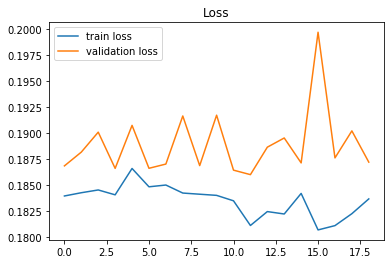

 20%|████████████████▊                                                                   | 1/5 [00:06<00:26,  6.53s/it]

0.7776445649152072 SEED: 8079
Train on 2800 samples, validate on 700 samples
Epoch 1/50
2800/2800 [==============================] - 0s 34us/step - loss: 0.1863 - rmse: 0.4304 - val_loss: 0.1846 - val_rmse: 0.4293
Epoch 2/50
2800/2800 [==============================] - 0s 32us/step - loss: 0.1846 - rmse: 0.4288 - val_loss: 0.1887 - val_rmse: 0.4336
Epoch 3/50
2800/2800 [==============================] - 0s 31us/step - loss: 0.1846 - rmse: 0.4285 - val_loss: 0.1859 - val_rmse: 0.4307
Epoch 4/50
2800/2800 [==============================] - 0s 34us/step - loss: 0.1856 - rmse: 0.4293 - val_loss: 0.1878 - val_rmse: 0.4329
Epoch 5/50
2800/2800 [==============================] - 0s 41us/step - loss: 0.1823 - rmse: 0.4262 - val_loss: 0.1859 - val_rmse: 0.4306
Epoch 6/50
2800/2800 [==============================] - 0s 37us/step - loss: 0.1847 - rmse: 0.4286 - val_loss: 0.1854 - val_rmse: 0.4303
Epoch 7/50
2800/2800 [==============================] - 0s 36us/step - loss: 0.1885 - rmse: 0.4326 - 

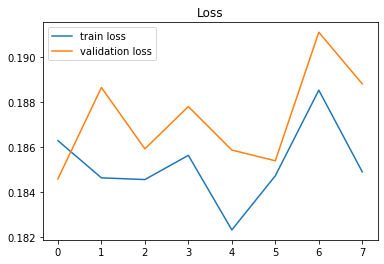

 40%|█████████████████████████████████▌                                                  | 2/5 [00:13<00:20,  6.70s/it]

0.7756854670558799 SEED: 4839
Train on 2800 samples, validate on 700 samples
Epoch 1/50
2800/2800 [==============================] - 0s 37us/step - loss: 0.1862 - rmse: 0.4308 - val_loss: 0.1858 - val_rmse: 0.4304
Epoch 2/50
2800/2800 [==============================] - 0s 33us/step - loss: 0.1877 - rmse: 0.4319 - val_loss: 0.1870 - val_rmse: 0.4322
Epoch 3/50
2800/2800 [==============================] - 0s 35us/step - loss: 0.1848 - rmse: 0.4285 - val_loss: 0.1888 - val_rmse: 0.4339
Epoch 4/50
2800/2800 [==============================] - 0s 38us/step - loss: 0.1815 - rmse: 0.4250 - val_loss: 0.1852 - val_rmse: 0.4300
Epoch 5/50
2800/2800 [==============================] - 0s 36us/step - loss: 0.1826 - rmse: 0.4265 - val_loss: 0.1863 - val_rmse: 0.4312
Epoch 6/50
2800/2800 [==============================] - 0s 34us/step - loss: 0.1848 - rmse: 0.4290 - val_loss: 0.1859 - val_rmse: 0.4307
Epoch 7/50
2800/2800 [==============================] - 0s 37us/step - loss: 0.1831 - rmse: 0.4272 - 

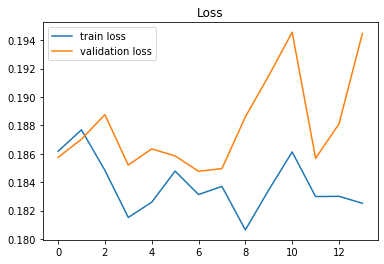

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:21<00:14,  7.12s/it]

0.7766889074228525 SEED: 4334
Train on 2800 samples, validate on 700 samples
Epoch 1/50
2800/2800 [==============================] - 0s 39us/step - loss: 0.1826 - rmse: 0.4263 - val_loss: 0.1856 - val_rmse: 0.4305
Epoch 2/50
2800/2800 [==============================] - 0s 34us/step - loss: 0.1840 - rmse: 0.4282 - val_loss: 0.1855 - val_rmse: 0.4301
Epoch 3/50
2800/2800 [==============================] - 0s 35us/step - loss: 0.1854 - rmse: 0.4297 - val_loss: 0.1871 - val_rmse: 0.4321
Epoch 4/50
2800/2800 [==============================] - 0s 35us/step - loss: 0.1848 - rmse: 0.4288 - val_loss: 0.1883 - val_rmse: 0.4334
Epoch 5/50
2800/2800 [==============================] - 0s 33us/step - loss: 0.1866 - rmse: 0.4315 - val_loss: 0.1895 - val_rmse: 0.4347
Epoch 6/50
2800/2800 [==============================] - 0s 35us/step - loss: 0.1834 - rmse: 0.4270 - val_loss: 0.1868 - val_rmse: 0.4318
Epoch 7/50
2800/2800 [==============================] - 0s 34us/step - loss: 0.1823 - rmse: 0.4257 - 

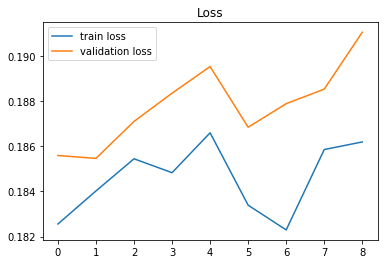

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:30<00:07,  7.56s/it]

0.7766715318320823 SEED: 3815
Train on 2800 samples, validate on 700 samples
Epoch 1/50
2800/2800 [==============================] - 0s 31us/step - loss: 0.1899 - rmse: 0.4345 - val_loss: 0.1852 - val_rmse: 0.4298
Epoch 2/50
2800/2800 [==============================] - 0s 37us/step - loss: 0.1845 - rmse: 0.4286 - val_loss: 0.1872 - val_rmse: 0.4323
Epoch 3/50
2800/2800 [==============================] - 0s 33us/step - loss: 0.1855 - rmse: 0.4296 - val_loss: 0.1879 - val_rmse: 0.4329
Epoch 4/50
2800/2800 [==============================] - 0s 34us/step - loss: 0.1854 - rmse: 0.4291 - val_loss: 0.1846 - val_rmse: 0.4291
Epoch 5/50
2800/2800 [==============================] - 0s 35us/step - loss: 0.1837 - rmse: 0.4270 - val_loss: 0.1874 - val_rmse: 0.4322
Epoch 6/50
2800/2800 [==============================] - 0s 41us/step - loss: 0.1862 - rmse: 0.4304 - val_loss: 0.1880 - val_rmse: 0.4330
Epoch 7/50
2800/2800 [==============================] - 0s 37us/step - loss: 0.1834 - rmse: 0.4276 - 

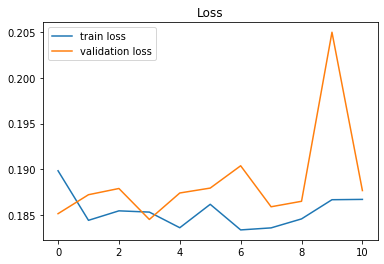

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:38<00:00,  7.67s/it]


In [6]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
    
    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)
    
    
    # Train the Model
    history = model.fit(X_train, y_train, epochs=50, batch_size=64, 
                        validation_data=(X_valid,y_valid), callbacks=[EarlyStopping(patience=7)], verbose=0)

    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make submissions
    submission = pd.DataFrame({
        "item_id": IDtest, 
        "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

17. 중분류&대분류(EF + gender CS)2: 1206

In [73]:
X_train = pd.read_csv('X_train_after_percentile_nm&mclas2.csv', encoding='cp949')
X_test = pd.read_csv('X_test_after_percentile_nm&mclas2.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender

i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

In [74]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
    
    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)
    
    # Make submissions
    submission = pd.DataFrame({
        "item_id": IDtest, 
        "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

 20%|████████████████▊                                                                   | 1/5 [00:06<00:26,  6.69s/it]

0.7684919724770644 SEED: 4573


 40%|█████████████████████████████████▌                                                  | 2/5 [00:14<00:20,  6.97s/it]

0.7718411175979984 SEED: 8799


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:20<00:13,  6.82s/it]

0.769056679177092 SEED: 8580


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:27<00:06,  6.66s/it]

0.7669498887962192 SEED: 7408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.12s/it]

0.7701079024186822 SEED: 2448
